In [5]:
import torch

In [7]:
!ws_allocate mySpace 30

Info: could not read email from users config ~/.ws_user.conf.
Info: reminder email will be sent to local user account
Info: creating workspace.
/hkfs/work/workspace/scratch/cv3721-mySpace
remaining extensions  : 3
remaining time in days: 30


In [8]:
!ws_list

/bin/ws_list:106: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open('/etc/ws.conf'))
/bin/ws_list:247: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  content = yaml.load(open(ws))
id: mySpace
     workspace directory  : /hkfs/work/workspace/scratch/cv3721-mySpace
     remaining time       : 29 days 23 hours
     creation time        : Wed Apr 28 16:56:33 2021
     expiration date      : Fri May 28 16:56:33 2021
     filesystem name      : hkfswork
     available extensions : 3


In [21]:
!ls /hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/


normalizedImg  Radiomics  rawImg  trainSet.txt


In [28]:
!cd /hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData

In [11]:
!ls

jupyterhub_slurmspawner_1400352.log  Untitled.ipynb
jupyterhub_slurmspawner_1400384.log


In [33]:
dfNew=df[['ImageFile','Prognosis']]

In [34]:
dfNew['ImageFile']='/hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/rawImg/'+dfNew['ImageFile']

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
!source hack_env/bin/activate

In [10]:
from PIL import Image

In [13]:
import numpy as np

In [6]:
from skimage import io, transform

In [37]:
imgList=sorted(dfNew['ImageFile'].values)

In [39]:
!python -m venv myEnv; source myEnv/bin/activate

In [22]:
!ls /hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/trainSet.txt

normalizedImg  Radiomics  rawImg  trainSet.txt


In [47]:
!source hack_env/bin/activate

In [4]:
import numpy as np

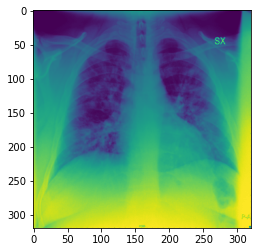

In [16]:
from skimage.transform import resize
plt.imshow(resize(np.array(io.imread('/hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/normalizedImg/P_131.png')), (320, 320)))

In [1]:
import pandas as pd

df = pd.read_csv('/hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/trainSet.txt', delimiter = ",")

In [4]:
dfNew=df[['ImageFile','Prognosis']]

In [5]:
dfNew['ImageFile']='/hkfs/work/workspace/scratch/ej4555-hida2021/HackathonCovidData/trainSet/normalizedImg/'+dfNew['ImageFile']

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [30]:
le.fit(dfNew['Prognosis'].values)

LabelEncoder()

In [31]:
X=dfNew['ImageFile'].values
y=le.transform(dfNew['Prognosis'].values)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
from torch.utils.data import Dataset, DataLoader

In [35]:
from skimage import io, transform

In [36]:
class CovidDataset(Dataset):
    def __init__(self, X, y, transform=None):

        self.X=X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        image = io.imread(self.X[idx])
        label = self.y[idx]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [37]:
CovidDataset(X_train,y_train)[0]

{'image': array([[145, 130, 116, ..., 138,  79,   0],
        [109,  91,  70, ...,  80,  37,   0],
        [ 70,  54,  36, ...,  41,  21,   0],
        ...,
        [ 55,  43,  32, ...,  17,  12,   0],
        [ 61,  54,  37, ...,  19,  12,   0],
        [ 74,  65,  50, ...,  21,  14,   0]], dtype=uint8),
 'label': 0}

In [2]:
import seaborn as sns

In [48]:
import pytorch_lightning as pl

ModuleNotFoundError: No module named 'pytorch_lightning'

In [49]:
from torch.nn import functional as F

In [ ]:
class COVID(pl.LightningModule):
    
    def __init__(self, train,val, model,batch_size=4, learning_rate=1e-4,transform):

        super().__init__()

        # Set our init args as class attributes
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model=model
        self.train=train
        self.val=val
        self.transform = transform


    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    #def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        #return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=4)

    #def test_dataloader(self):
        #return DataLoader(self.mnist_test, batch_size=32)